In [1]:
#import libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle

In [2]:
#pull the datasets
df=pd.read_csv(r'data_scaled.csv', index_col=False)
df_test=pd.read_csv(r'test_scaled.csv', index_col=False)

In [3]:
#Model selection and building

#Model Selection
#Split the dataset
X=df.loc[:, df.columns != 'is_promoted']
y=df['is_promoted']

In [4]:
#Resampling for imbalanced data
X_resample, y_resample  = SMOTE().fit_resample(X, y)

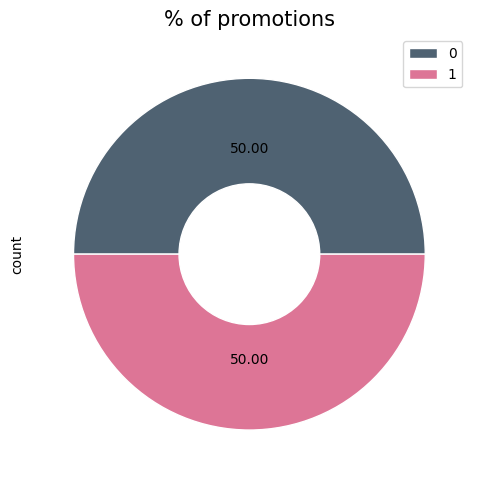

In [5]:
#Donut chart
colors = ['#4F6272', '#DD7596']
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))
y_resample.value_counts().head(3).plot(kind='pie', labels=None, autopct='%.2f', ax=ax1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors).legend(labels={
                     1,0})
central_circle = plt.Circle((0, 0), 0.4, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title('% of promotions', size=15)
plt.tight_layout()
plt.savefig('images/donut_chart_after_resampling.png', dpi=300)
plt.show()

In [6]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=42)

In [9]:
#Model building
dt = DecisionTreeClassifier()
lr = LogisticRegression()
rf = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [dt, lr, rf, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "Random Forest", 3: "Naive Bayes", 4: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X_train, y_train, cv = 10, scoring = "accuracy").mean()))

Decision Tree Accuracy: 0.9200862466805342
Logistic Regression Accuracy: 0.7929172262878106
Random Forest Accuracy: 0.9555993360275945
Naive Bayes Accuracy: 0.6793229375791421
K-Neighbors Accuracy: 0.8908805984216471


In [11]:
#Hyperparamater Tuning
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

# fitting the model for grid search
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)
print("Best Estimator:", best_estimator)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Accuracy: 87.90 %
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
Best Estimator: DecisionTreeClassifier(max_depth=20, min_samples_leaf=5)


In [12]:
#Best Model
Classifier = RandomForestClassifier(criterion= 'gini', max_depth= 20, min_samples_leaf= 5)
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)
print('Test Accuracy: ', grid_search.score(X_test, y_test))

Test Accuracy:  0.8894096529716793


In [13]:
#Metrics
accuracy_score(y_test, Prediction)

0.8915536497806142

Unnormalized Confusion Matrix


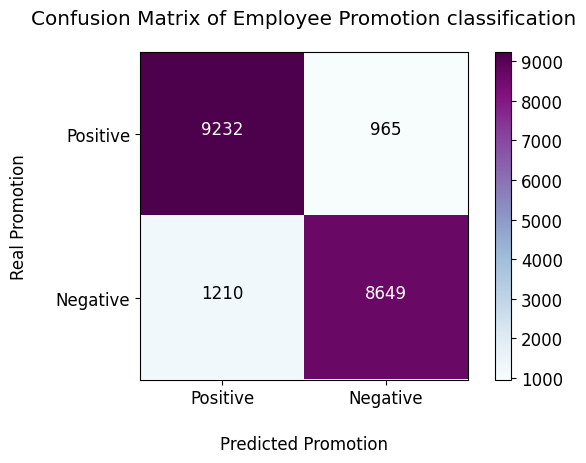

In [14]:
#Confusion Matrix
ConfusionMatrix = confusion_matrix(y_test, Prediction)

# Plotting Function for Confusion Matrix
colors = ['#4F6272', '#DD7596']

def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.BuPu):
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title, pad = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    

    if normalized:
        cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Unnormalized Confusion Matrix")
  
    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.xlabel("Predicted Promotion", labelpad = 20)
    plt.ylabel("Real Promotion", labelpad = 20)
    
plot_cm(ConfusionMatrix, classes = ["Positive", "Negative"], title = "Confusion Matrix of Employee Promotion classification")
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=300)

In [15]:
print(classification_report(y_test, Prediction))


              precision    recall  f1-score   support

           0       0.88      0.91      0.89     10197
           1       0.90      0.88      0.89      9859

    accuracy                           0.89     20056
   macro avg       0.89      0.89      0.89     20056
weighted avg       0.89      0.89      0.89     20056



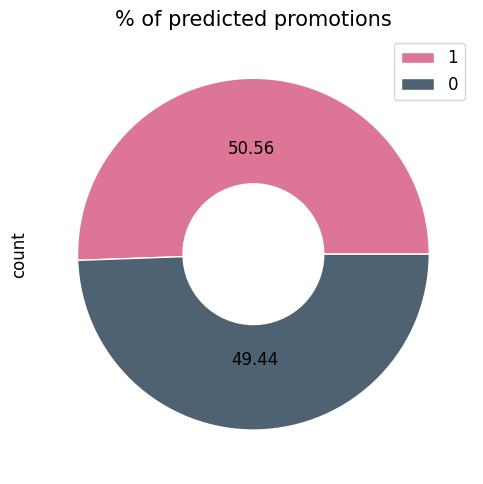

In [16]:
#Predictions for next year
prediction_upcoming = Classifier.predict(df_test)
df_pred = pd.DataFrame(prediction_upcoming , columns = ['Predictions'])
predicts=df_pred['Predictions'].value_counts()
df_pred.to_csv('df_pred.csv', index=False)

colors = ['#DD7596', '#4F6272']
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))
df_pred.Predictions.value_counts().plot(kind='pie', labels=None, autopct='%.2f', ax=ax1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors).legend(labels={
                     "1","0"})
central_circle = plt.Circle((0, 0), 0.4, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title('% of predicted promotions', size=15)
plt.tight_layout()
plt.savefig('images/pred_donut_chart.png', dpi=300)
plt.show()

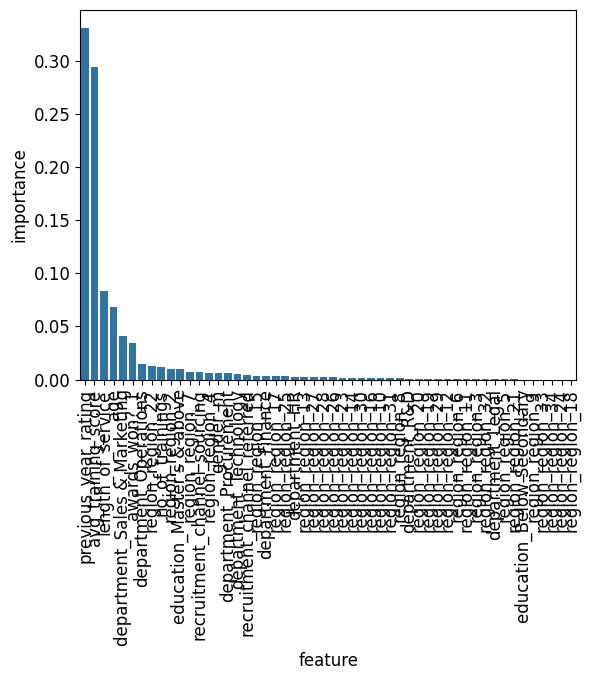

In [17]:
#Feature importances
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importance = {}
for i in range(len(X_train.columns)):
    feature_importance[X_train.columns[i]] = feature_importances[i]
importance_df = pd.DataFrame(list(feature_importance.items()),columns=['feature','importance'])
importance_df = importance_df.sort_values('importance',ascending=False)
plt.xticks(rotation='vertical')
plt.rcParams['figure.figsize'] = [50, 10]
sns.barplot(x="feature",y="importance",data=importance_df)
plt.savefig('images/feature_importances.png')
plt.show()

#pickle the model
pickl = {'model': grid_search.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']